# Генерация кода по вопросам со StackOverflow

[Оригинал](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)

Обучим seq2seq модель, которая, по последовательности токенов одного вида (а именно — последовательности слов естественного языка, из которых состоит вопрос), генерирует последовательность токенов другого вида — а именно, команды, операторы, имена переменных, пунктуация... которую мы используем при написании кода. Для простоты ограничимся примерами из одного языка — python.

Самые популярные sequence to sequence модели — это модели вида "**encoder-decorder**", которые разбирались в лекции:
- они используют RNN для того, чтобы закодировать входную последовательность в некоторый вектор (представление входного предложения в некоторым заранее зафиксированном формате)
- этот вектор декодируется второй RNN (декодером), который учится предсказывать выходную последовательность, генерируя последовательно токен за токеном

In [1]:
QUICK_RUN = True    # использовать уже готовую модель

## Еще раз теория

<img src="./img/seq2seq.png" width="500">

**RNN энкодер**
- на вход мы подаём токенизированную фразу последовательно по 1 токену
  - в каждый момент времени, входом энкодера является текущей токен — назовём его "x", а также некоторое скрытое состояние — назовём его "h" (от слова "hidden")
- на каждый следующий скрытый слой подается скрытое состояние предыдущего шага
  - на выходе новое скрытое состояние
  - скрытое состояние содержит в себе информацию обо всём предложении, которую сеть видела к текущему моменту
- нулевое скрытое состояние можно инициализировать нулями или использовать, например, равномерное распределение
- как только последнее слово было передано в RNN, будем использовать последнее скрытое состояние как вектор, содержащий в себе информацию обо всём предложении

**RNN декодер**
- имея выход энкодера, можно начинать декодировать его — генерировать выходную последовательность
- нулевое скрытое состояние декодера - это последнее скрытое состояние энкодера
- на каждом шаге нам нужно предсказывать следующее слово
  - для этого будем на каждом шаге пропускать текущее скрытое состояние через линейный слой и предсказывать следующее слово
- после того как мы сгенерировали всю выходную последовательность, мы можем сравнить её с переводом из нашей обучающей выборки

**Обновление весов**
- считаем функцию потерь
- делаем backward-шаг, посчитав градиент функции потерь
- обновляем веса сети, в направлении минимизации функции потерь

**Дополнительные фишки**

- "**teacher forcing**"[1,2] - метод для обучения RNN, который в некотором (заранее зафиксированном) проценте случаев использует в качестве входа "[ground truth](https://en.wikipedia.org/wiki/Ground_truth#Statistics_and_machine_learning)" (короче, таргет) с предыдущего шага, а не предсказанное сетью значение
- подход, который касается **длины генерируемой последовательности**:
  - не обязательно ждать, пока модель сгенерирует end-of-sequence токен
  - вместо этого, прекратить генерацию, когда мы выдали достаточное количество слов
    - например, когда длина выходной последовательности стала примерно равна длине и входной последовательности
  - это позволит нам избежать слишком долгого обучения, либо генерирования излишнего количества символов в конце последовательности (которые скорее всего будут = `<PAD>`)

[1] Williams R. J., Zipser D. A learning algorithm for continually running fully recurrent neural networks //Neural computation. – 1989. – Т. 1. – №. 2. – С. 270-280.  
[2] Lamb A. M. et al. Professor forcing: A new algorithm for training recurrent networks //Advances In Neural Information Processing Systems. – 2016. – С. 4601-4609.

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

import random
import math
import time

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)
device

device(type='cuda')

### Еще полезные штуки

- Таблица параметров модели. Типа подробный `get_parameters()` 
- Все тензоры ноутбука
- Очистить память от ненужных тензоров/моделей

In [ ]:
from helpers.summary import count_parameters, dump_tensors, free_mem

### Посмотрим, что представляют собой данные
- intent - вопрос, заданные стаковерфлоу
- snippet - кусок кода в самом популярном ответе на вопрос

In [9]:
import pandas as pd

df = pd.read_csv("./datasets/stackoverflow_code_generation/conala/conala-train.csv")
df.head()

,intent,snippet
0,How to convert a list of multiple integers int...,"sum(d * 10 ** i for i, d in enumerate(x[::-1]))"
1,How to convert a list of multiple integers int...,"r = int(''.join(map(str, x)))"
2,how to convert a datetime string back to datet...,datetime.strptime('2010-11-13 10:33:54.227806'...
3,Averaging the values in a dictionary based on ...,"[(i, sum(j) / len(j)) for i, j in list(d.items..."
4,zip lists in python,"zip([1, 2], [3, 4])"


Нам нужно написать токенизаторы, которые помогут нам поделить на токены вопросы со StackOverflow и кусочек кода

- `tokenize_question` токенизирует наш вопрос — делает это с помощью простой регулярки, убирает слишком длинные слова, которые, скорее всего, являются названиями веб-сайтов, либо слишком длинными названиями каких-то текстовых полей и т.п. Возвращает токены в обратном порядке: `[::-1]`. Зачем в обратном порядке:
  - значительно (?) улучшает работу LSTM и подобных сетей, причем точно не ясно почему (работает только в однонаправленном варианте, тут конкретно это ничего не даст, но и не поломает ничего, т.к. RNN инвариантна к развороту последовательности (но не к порядку как CNN)). Тут это просто чтоб показать, как обычно делают:
    - предполагается, что когда сеть обучается и сравнивают данные и таргет, то их "как бы конкатенируют последовательно друг за другом", т.е. развернутые первые токены входа оказываются рядом с первыми токенами выхода и сеть лучше улавливает их корреляцию (звучит как-то неубедительно, но объясняют [так](https://arxiv.org/abs/1409.3215))

- `tokenize_snippet` токенизирует кусок кода похожим образом

In [10]:
import re

def tokenize_question(text):
    """
    Tokenizes question from a string into a list of strings (tokens) and reverses it
    """
    return list(filter(lambda x: len(x) < 16, re.findall(r"[\w']+", text)[::-1]))

def tokenize_snippet(text):
    """
    Tokenizes code snippet into a list of operands
    """
    return list(filter(lambda x: len(x) < 10, re.findall(r"[\w']+|[.,!?;:@~(){}\[\]+-/=\\\'\"\`]", text)))

### Обработчик входныx данных на `torchtext`

- `Field` позволяет нам определить, как должны обрабатываться данные (т.е. переводится текст в тензоры)
  - создаем поля SRC и TRG, они будут образованы функциями токенизации с добавлением токенов начала/конца последовательности и переводом всего текста в нижний регистр
  - для вопросов будет также учитываться их длина (пригодится для обучения модели)
- `TabularDataset` класс для создания объекта датасета из файлам с данным (cvs, tsv, json)
  - проходит по 3 файлам, где выборка уже поделена авторами курса на обучающую (2000 вопросов), валидационную (379) и тестовую (500)
  - если надо, может сам делить на трейн/тест (т.к. потомок `Dataset`)
- `BucketIterator` итератор для получения пакетов (батчей) из датасета (далее)

In [11]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

SRC = Field(
    tokenize = tokenize_question, 
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
    include_lengths = True
)

TRG = Field(
    tokenize = tokenize_snippet, 
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True
)

fields = {
    'intent': ('src', SRC),
    'snippet': ('trg', TRG)
}

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
train_data, valid_data, test_data = TabularDataset.splits(
                            path = 'datasets/stackoverflow_code_generation/conala/',
                            train = 'conala-train.csv',
                            validation = 'conala-valid.csv',
                            test = 'conala-test.csv',
                            format = 'csv',
                            fields = fields
)

Кроме того, данные с похожей тематикой можно найти, загуглив следующее сочетание слов: "StackOverflow question code dataset". Это датасет, намайненный автоматически со StackOverflow, с помощью "Bi-View Hierarchical Neural Network". Там порядка 150 тыс. вопросов. Cтатья про "bi view hierarchical neural network" была представлена в 2018 году[1].

[1] Yao Z. et al. Staqc: A systematically mined question-code dataset from stack overflow //Proceedings of the 2018 World Wide Web Conference. – 2018. – С. 1693-1703.

### Cформируем словарь

Задаём максимально возможный размер слоя и минимальную встречаемость слова для того, чтобы попасть в словарь (3 для вопросов, 5 для кода).

Чтобы использовать паддинг, `torchtext` требует, чтобы все элементы в батче были отсортированы по их длине до применения паддинга, в убывающем порядке. То есть, первая последовательность должна быть самой длинной

In [12]:
SRC.build_vocab([train_data.src], max_size=25000, min_freq=3)
print(SRC.vocab.freqs.most_common(20))


TRG.build_vocab([train_data.trg], min_freq=5)
print(TRG.vocab.freqs.most_common(20))

print(f"Уникальные токены в словаре интентов: {len(SRC.vocab)}")
print(f"Уникальные токены в словаре сниппетов: {len(TRG.vocab)}")

[('a', 1285), ('in', 949), ('python', 922), ('to', 851), ('how', 633), ('of', 602), ('list', 558), ('string', 397), ('the', 328), ('from', 275), ('with', 228), ('pandas', 192), ('i', 191), ('dictionary', 162), ('get', 151), ('convert', 134), ('values', 131), ('do', 125), ('dataframe', 111), ('into', 110)]
[(')', 3480), ('(', 3475), ('.', 2595), (',', 1899), ('[', 1122), (']', 1121), ('=', 927), ("'", 885), ('\\', 697), (':', 587), ('in', 504), ('x', 498), ('"', 496), ('for', 450), ('1', 377), ('-', 279), ('a', 265), ('0', 259), ('/', 257), ('df', 234)]
Уникальные токены в словаре интентов: 612
Уникальные токены в словаре сниппетов: 395


In [13]:
print(f"Размер обучающей выборки: {len(train_data.examples)}")
print(f"Размер валидационной выборки: {len(valid_data.examples)}")
print(f"Размер тестовой выборки: {len(test_data.examples)}")

Размер обучающей выборки: 2000
Размер валидационной выборки: 379
Размер тестовой выборки: 500


### Итератор для батчей

Экземпляр `BucketIterator` возвращает батчи с данными, у которых есть атрибут 
- "src" — это тензоры, кодирующие входные вопросы
- "trg" (target) — это тензоры, кодирующие сниппеты с кодом. 

Удобно, что torchtext-итераторы умеют 
- автоматически добавлять паддинг
-  `BucketIterator` умеет минимизировать количество паддинга для входов и выходов

In [14]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

### Класс энкодера

Двухслойный LSTM. *И мы используем модификацию **GRU** (Управляемые рекуррентные нейроны, Gated recurrent units), что почти тоже самое, но чуть меньше параметров, чуть меньше операций обновления весов, чуть меньше переобучается, при этом на практике показатели качества практически от LSTM не отличаются* 

Для многослойной LSTM/GRU входная последовательность идёт в первый слой сети, а скрытое состояние первого слоя используется как входная последовательность следующего слоя. Скрытое состояние первого слоя можно представить формулой, зависящей от входных токенов и от предыдущего скрытого состояния. Напомню что, в отличие от RNN, LSTM, кроме того, что берёт на вход предыдущее скрытые состояние и возвращает следующее, ещё и принимает на вход так называемое "cell state". Его обычно обозначают буквой "c". Можно воспринимать его как другой вид скрытого состояния. В итоге, конечное представление входной последовательности в виде вектора будет конкатенацией скрытого состояния и нашего cell state, которое будем обозначать буквой "с".

`__init__` 
- входная размерность данных — это размерности наших "one-hot" векторов
- размерность эмбеддингов, размерность слоя с эмбеддингами — например, можно сделать его равным 100 или 200, любому другому числу, которое кажется вам наиболее подходящим (зашибись теория)
-  "encoding hidden dimension" (вот он) — это размерность скрытого состояния (количество ячеек памяти, максимальная длина взаимосвязанной последовательности)
-  "dec_hid_dim" - размерность, которую нужно выдавать на декодер
-   "dropout" — это количество дропаута. Он будет включаться между ембеддингом и рекурренткой. Дропаут в рекуррентных сетях - это отдельная тема, мы не можем нарушать рекуррентные связи внутри RNN, иначе мы фактически лишаем сеть памяти

`forward`
- ембеддинг -> дропаут -> упаковка -> RNN -> распаковка -> tanh -> скрытое состояние
- все размерности подписаны, можно поразбираться


In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))    # dropout(!)
        
        #embedded = [src sent len, batch size, emb dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.detach().cpu())   # тензор длины д.б. на хосте
        packed_outputs, hidden = self.rnn(packed_embedded)
                     
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 

        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

**Упаковка, распаковка** выровненных паддингом последовательностей
- все RNN классы умеют принимать данные в таком виде
- длины последовательностей must be on the CPU if provided as a tensor
- справка ни о чем, походу, это просто `vstack` всех последовательностей в одну

In [16]:
x = torch.tensor([[1, 2, 0, 0], 
                  [1, 2, 3, 4]])                # Batch X MaxIn
emb = nn.Embedding(x.shape[-1] + 1, 2)(x)       # Batch X MaxIn X Emb
packed = nn.utils.rnn.pack_padded_sequence(emb, [4, 4, 4, 4])
packed

PackedSequence(data=tensor([[-1.0115,  0.2167],
        [-0.6123,  0.5036],
        [ 0.0461,  0.4024],
        [ 0.0461,  0.4024],
        [-1.0115,  0.2167],
        [-0.6123,  0.5036],
        [ 0.2310,  0.6931],
        [-0.2669,  2.1785]], grad_fn=<PackPaddedSequenceBackward0>), batch_sizes=tensor([4, 4, 4, 4]), sorted_indices=None, unsorted_indices=None)

### Механизм внутреннего внимания

Будем использовать стандартный attention, который посчитает нам веса по нашей входной последовательности

In [17]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Класс декодера

Ахритерктура аналогичная энкодеру.

- первый слой получает пару с прошлого шага и прогоняет её через нашу сеть вместе с текущим токеном, чтобы предсказать новую пару
- прогоняем наше скрытое состояние с верхнего слоя через линейный слой, чтобы сделать предсказание следующего токена в выходном генерируемом предложении

Параметры:
- "output_dimension" (это размер one-hot векторов, которые подаются на вход декодеру). Это число должно быть равно размеру словаря таргета.

Форвард:
- unsqueeze к входным токенам, чтобы добавить ещё одну размерность
- аналогично энкодеру, применяем эмбеддинг-слой и дропаут.
- применяем attention
- батч с токенами передаём в RNN вместе с "h" и "c" векторами с предыдущего шага
- получаем на выходе output (это скрытое состояние с верхнего слоя нашей сети), новое скрытое состояние и новое cell состояние, то есть новые вектора "h" и "c"
- прогоняем output (после того, как избавились от лишней размерности) через линейный слой, чтобы получить предсказание следующего слова в нашей последовательности
- возвращать здесь мы будем, собственно — output, скрытое состояние и вектор "а"

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

### Seq2seq модель

Объединяет все это в кучу.

Входные параметры seq2seq модели —это энкодер, декодер, device, а также токены, с помощью которых мы кодируем паддинг, начало последовательности и конец последовательности.

Нужно убедиться, что количество слоёв и размерность скрытых состояний — одинакова для энкодера и декодера. Это не обязательное условие, но в противном случае (в случае разного количества слоёв) нам придётся придумывать некоторые способы это обойти
- Например, если в энкодере два слоя, а в декоре один, то можно использовать оба вектора, либо можно их усреднить.

"forward"-метод в классе seq2seq берёт на вход вопрос, сниппет с кодом и "teacher forcing ratio".  На выход он отдаёт нам output, а также веса attention, которые мы посчитали в модуле attention

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

# Инициализация модели

Сделаем так, чтобы количество слоёв у энкодера и декодера, а также размерности векторов скрытых состояний были одинаковыми. 

dropout будет достаточно большим ("0.8"). Если меньше, то плохо учится

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 100
DEC_HID_DIM = 100
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
PAD_IDX = SRC.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

Так задаются в торче пользовательские функции иницализации:
- параметры веса - нормальный шум
- остальные параметры - 0

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(612, 128)
    (rnn): GRU(128, 100, bidirectional=True)
    (fc): Linear(in_features=200, out_features=100, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=300, out_features=100, bias=True)
    )
    (embedding): Embedding(395, 128)
    (rnn): GRU(328, 100)
    (out): Linear(in_features=428, out_features=395, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
)

In [22]:
def cnt_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель содержит {cnt_parameters(model):,} параметров')

Модель содержит 615,651 параметров


In [23]:
count_parameters(model)

+----------------------------------+-----+-----------+------------+---------------+----------+
|         Modules/Tensors          | GPU |   Shape   | Parameters |      Type     |  Memory  |
+----------------------------------+-----+-----------+------------+---------------+----------+
|     encoder.embedding.weight     |  +  | 612 x 128 |   78336    | torch.float32 | 6893568  |
|     encoder.rnn.weight_ih_l0     |  +  | 300 x 128 |   38400    | torch.float32 | 3379200  |
|     encoder.rnn.weight_hh_l0     |  +  | 300 x 100 |   30000    | torch.float32 | 2640000  |
|      encoder.rnn.bias_ih_l0      |  +  |    300    |    300     | torch.float32 |  26400   |
|      encoder.rnn.bias_hh_l0      |  +  |    300    |    300     | torch.float32 |  26400   |
| encoder.rnn.weight_ih_l0_reverse |  +  | 300 x 128 |   38400    | torch.float32 | 3379200  |
| encoder.rnn.weight_hh_l0_reverse |  +  | 300 x 100 |   30000    | torch.float32 | 2640000  |
|  encoder.rnn.bias_ih_l0_reverse  |  +  |    300 

615651

Then we define our optimizer and criterion. We have already initialized `PAD_IDX` when initializing the model, so we don't need to do it again.

In [24]:
optimizer = optim.Adam(model.parameters())

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

- переводим модель в training mode (с помощью model.train). 
  - Это включит dropout и батч-нормализацию (если бы она была, но, в нашем случае, мы её не используем). 
- итерируемся через батч-итератор. Что мы делаем на каждой итерации? 
  - берём входное и выходное предложение из батча, вместо входного предложения мы получаем пару — "входное предложение и его длина" (как мы уже обсуждали ранее). 
  - делаем zero_grad — обнуляем градиенты, посчитанные на предыдущем шаге, 
  - передаём source и target в нашу модель и получаем некоторый выход и веса attention, 
  - считаем градиенты с помощью "loss backward", предварительно посчитав функцию потерь, 
  - клипаем (clip) градиенты (это популярный паттерн, и недопускает "взрыва градиента")
  - делаем шаг нашим оптимизатором и считаем лосс. 

Замечательно, на выход наша функция будет возвращать нормализованный (по выборке) лосс по нашей эпохе.

## Обучение модели

In [26]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len, trg, 0.4)    #turn ON teacher forcing
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Также у нас есть функция, которую мы будем использовать для оценивания качества модели (для evaluate). Здесь, вначале, мы переводим нашу модель в состояние оценивания качества (это означает "выключить dropout", "выключить батч-нормализацию") и дальше проделываем примерно такие же шаги, как и в функции "train".

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output, attention = model(src, src_len, trg, 0.0)   #turn OFF teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

 Кроме того, давайте напишем функцию, которая будет замерять время, потраченное на каждую эпоху, и назовём её "epoch_time".

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Перплексия** в теории информации — безразмерная величина, мера того, насколько хорошо распределение вероятностей предсказывает выборку. Низкий показатель перплексии указывает на то, что распределение вероятности хорошо предсказывает выборку.

Формула перплексии:

$$PP(W) = P(w_1, w_2, .., w_N)^{-\frac{1}{N}} = \sqrt[N]{\dfrac{1}{P(w_1, w_2, .., w_N)}} = \sqrt[N]{\dfrac{1}{\prod_{i=1}^N P(w_i | w_1, .., w_{i-1})}}$$
​
- Можно использовать перплексию для сравнения двух нейросетей с разными архитектурами на одной и той же задачи (обе нейросети обучены переводить текст с языка А на язык Б)
- Перплексия связного текста ниже, чем перплексия произвольного набора слов

Минимум 100 эпох, чтоб не совсем мусор генерился, хоть и по памяти из трейна (датасет совсем небольшой)
- около 10 мин.

In [29]:
N_EPOCHS = 100
CLIP = 1        # более высокие градиенты обрезаются до этого значения

best_valid_loss = float('inf')

if not QUICK_RUN:  
    for epoch in range(N_EPOCHS):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), './models/conala_model_attention_test.pt')
        
        print(f'Эпоха: {epoch+1:02} | Время: {epoch_mins}m {epoch_secs}s')
        print(f'Перплексия (обучение): {math.exp(train_loss):7.3f}')
        print(f'Перплексия (валидация): {math.exp(valid_loss):7.3f}')

In [30]:
if QUICK_RUN:
    model.load_state_dict(torch.load('./models/conala_model_attention_test.pt'))

test_loss = evaluate(model, test_iterator, criterion)
print(f'Перплексия (валидация): {math.exp(test_loss):7.3f}')

Перплексия (валидация):  31.944


## Предсказание кода по вопросу

In [31]:
def translate_sentence(model, sentence):
    model.eval()
    tokenized = tokenize_question(sentence) 
    tokenized = ['<sos>'] + [t.lower() for t in tokenized] + ['<eos>']
    numericalized = [SRC.vocab.stoi[t] for t in tokenized] 
    sentence_length = torch.LongTensor([len(numericalized)])
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [TRG.vocab.itos[t] for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

In [32]:
import numpy as np

def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    ax.matshow(attention, cmap='bone')    # 2д матрица -> тепловая карта
        
    question = ['<sos>'] + [t.lower() for t in tokenize_question(candidate)] + ['<eos>']
    answer = translation
    
    ax.set(xticks=np.arange(attention.shape[-1]),
           yticks=np.arange(attention.shape[0]),
           xticklabels=question, 
           yticklabels=answer,
           title="Карта внимания",
           xlabel='Запрос',
           ylabel='Ответ')
    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="default")
    plt.show()
    plt.close()

In [33]:
example_idx = 2

src = ' '.join(vars(train_data.examples[example_idx])['src'])
trg = ' '.join(vars(train_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = object datetime to back string datetime a convert to how
trg = datetime . strptime ( '2010 - 11 - 13 10 : 33 : 54 . 227806' , ' y - m - d h : m : s . f' )


predicted trg =  datetime . datetime . now ( ) )


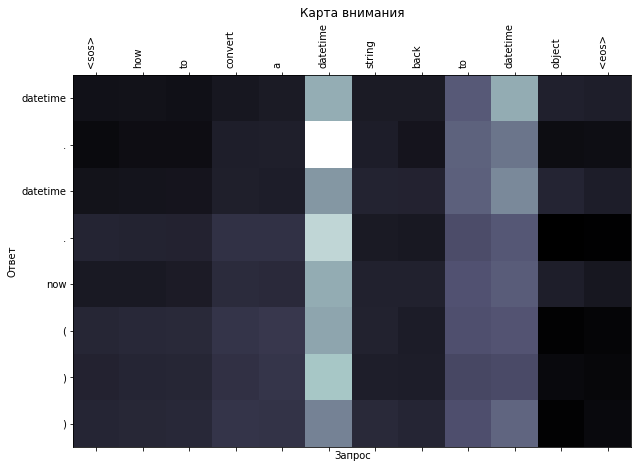

torch.Size([8, 1, 12])

In [34]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

In [35]:
example_idx = 8

src = ' '.join(vars(valid_data.examples[example_idx])['src'])
trg = ' '.join(vars(valid_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = string to tuple convert python
trg = " " " " " " . join ( ( 'a' , 'b' , 'c' , 'd' , 'g' , 'x' , 'r' , 'e' ) )


predicted trg =  <unk> ( ' ( ' , <unk> )


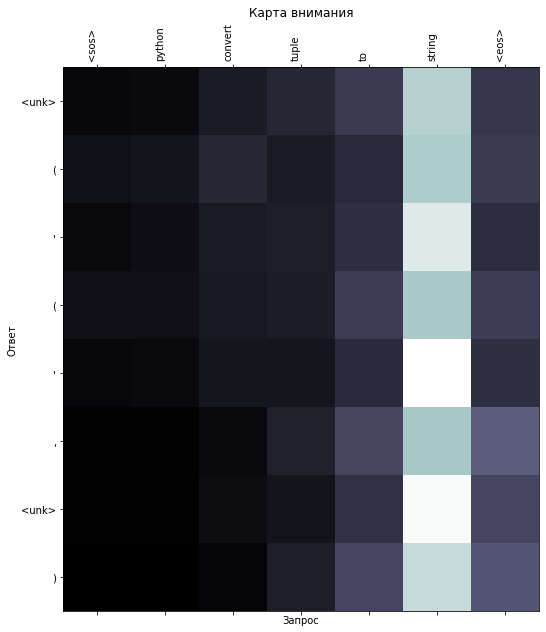

In [36]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

In [37]:
example_idx = 4

src = ' '.join(vars(test_data.examples[example_idx])['src'])
trg = ' '.join(vars(test_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = 8 utf to 1251 cp from string a convert to how
trg = d . decode ( 'cp1251' ) . encode ( 'utf8' )


predicted trg =  print(<unk>.<unk>(<unk>)


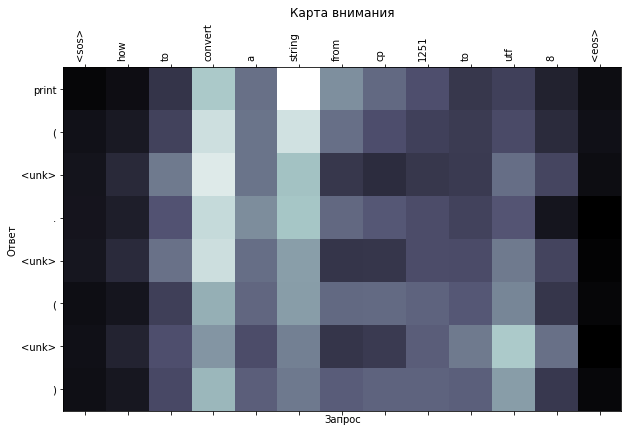

In [38]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ''.join(translation))

display_attention(src, translation, attention)

# До.за.

При обучении seq2seq модели из семинара качество работы модели оказалось не слишком хорошим. У этого есть несколько причин:

- Слишком маленький датасет. На 2000 пар сложно обучить хорошую модель для решения такой сложной задачи.
- Модель очень простая (чиво?:)), есть смысл попробовать усложнить ее (использовать другие архитектуры, например, Трансформер, разобранный в предыдущих лекциях и семинарах).
- Стоит более аккуратно подбирать параметры модели. Обратите внимание на:
  - Процесс построения словаря. Может быть, нужно поварьировать параметры min_freq, max_freq.
  - Dropout. Есть ли смысл добавлять еще больше dropout в модель?
  - Стратегия изменения learning rate в процессе обучения.
  - 
В качестве домашнего задания мы предлагаем Вам поэкспериментировать с кодом этого семинара и улучшить качество работы модели.